In [1]:
### mounting google colab ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



NLP From Scratch: Classifying Names with a Character-Level RNN
**************************************************************

**We addopted this example from PyTorch and added some modifications to classify different names in 18 languages**

For the exact code please refer to `Sean Robertson <https://github.com/spro/practical-pytorch>`_



We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

This code specifically, will be trained on a few thousand surnames from 18 languages of origin, and then will predict which language a name is from based on the

spelling:




**Data Pre Processing Begins**

In [2]:
####import required modules###########
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
def findFiles(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print('number of letters=',n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

###read the data 

###Indicate the data path directory##########
input_dir='/content/drive/MyDrive/RNN/char_classification/data_class/data/names/'

##### Reading and storing the data in a dictionary category_lines####
for filename in findFiles(input_dir+'*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

number of letters= 57
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
print(category_lines['Italian'][:5])
print(category_lines['French'][:5])
print(len(category_lines))

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
18


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Data pre processing ends**

Creating Networks
====================

Here, we define a simple RNN module, which is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.






In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)



tensor([[-2.9047, -2.9288, -2.8225, -2.8032, -2.9453, -2.9193, -2.9226, -2.8710,
         -2.9929, -2.7662, -2.9384, -2.8814, -2.9595, -2.8167, -2.9504, -2.8311,
         -2.8163, -2.9975]], grad_fn=<LogSoftmaxBackward0>)


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


We will also want a quick way to get a training example (a name and its
language):




In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Vives
category = Japanese / line = Ibu
category = Scottish / line = Mackenzie
category = Japanese / line = Nakajima
category = Portuguese / line = Paredes
category = Spanish / line = Solo
category = Russian / line = Jakhimovich
category = Vietnamese / line = Thuy
category = Vietnamese / line = Vinh
category = English / line = Mclaughlin


In [11]:
print(line_tensor.size())
print(line[3])
for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

torch.Size([10, 1, 57])
a


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` ( negative log likelihood loss)is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [12]:
criterion = nn.NLLLoss()
#learning_rate = 0.005 
#optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

Since the words do not have the same length, each word is fed one at a time, as shown in the below figure. The hidden output connects all the layers such that the hidden from the previous layer is fed to the current layer

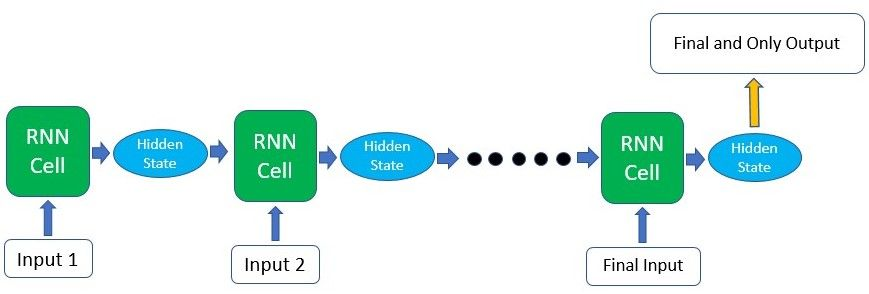

Indeed, the outputs of the layers except the last layer is not really used (only hiddens are used). The SoftMax function is applied to the last output. 

In [13]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [14]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 9s) 2.8470 Fay / Chinese ✗ (French)
10000 5% (0m 14s) 1.3575 Kuai / Vietnamese ✗ (Chinese)
15000 7% (0m 19s) 2.6898 Kwang  / Arabic ✗ (Korean)
20000 10% (0m 24s) 2.5993 Casey / Czech ✗ (Irish)
25000 12% (0m 29s) 1.1386 Mackenzie / Scottish ✓
30000 15% (0m 34s) 0.8329 Jeong / Korean ✓
35000 17% (0m 39s) 2.1267 Watt / German ✗ (Scottish)
40000 20% (0m 44s) 2.9819 Driml / Irish ✗ (Czech)
45000 22% (0m 50s) 1.0265 Boyle / Scottish ✓
50000 25% (0m 55s) 1.4234 Redden / English ✓
55000 27% (1m 0s) 0.3289 Tieu / Vietnamese ✓
60000 30% (1m 5s) 2.3436 Ferraro / Portuguese ✗ (Italian)
65000 32% (1m 10s) 2.0748 Driml / German ✗ (Czech)
70000 35% (1m 15s) 0.9876 England / English ✓
75000 37% (1m 20s) 1.7988 Bernat / French ✗ (German)
80000 40% (1m 25s) 0.4689 Blaise / French ✓
85000 42% (1m 30s) 0.3685 Escarra / Spanish ✓
90000 45% (1m 35s) 0.6253 Panzavecchia / Italian ✓
95000 47% (1m 40s) 0.7304 Klimek / Polish ✓
100000 50% (1m 46s) 0.5594 Kozumplikova / Czech ✓
105000 52% (1m 51s) 2.

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




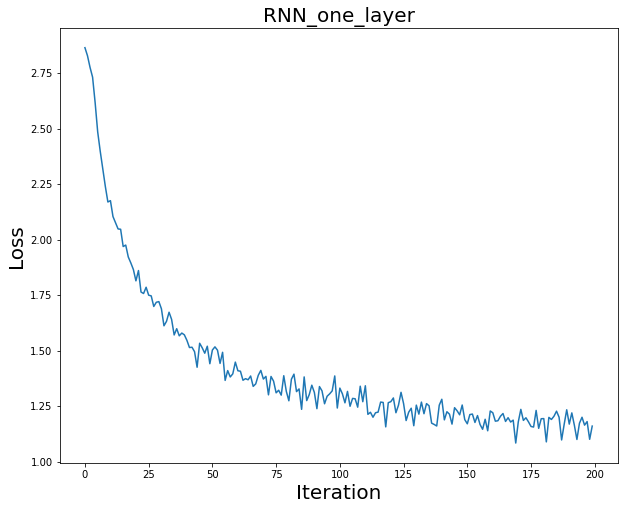

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

plt.subplots(figsize=(10,8))
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('RNN_one_layer',fontsize=20)
plt.plot(all_losses)


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




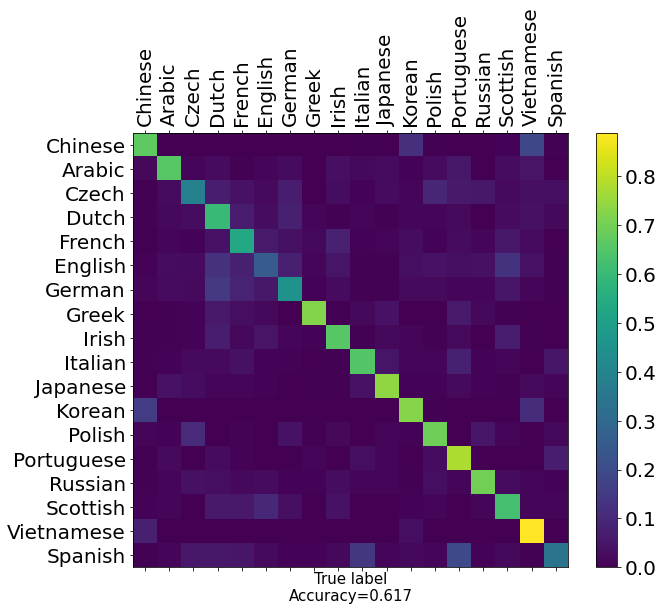

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
y_true=[]
y_pred=[]
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    y_true.append(category_i)
    y_pred.append(guess_i)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()



# Set up plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

score = accuracy_score(y_true, y_pred)
ax.set_xlabel('True label\nAccuracy={:0.3f}'.format(score),fontsize=15)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Hassan')


> Dovesky
(-0.50) Russian
(-1.10) Czech
(-3.83) English

> Jackson
(-0.98) English
(-1.28) Scottish
(-1.41) Russian

> Satoshi
(-0.72) Italian
(-1.80) Arabic
(-1.91) Japanese

> Hassan
(-1.13) Arabic
(-1.15) Scottish
(-2.48) English


Here, we define a more complicated RNN module, which has 2 rnns followed by a simple linear layer, which operate on an input and hidden state, with
a LogSoftmax layer after the output.

In [18]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2h_2 = nn.Linear(output_size + hidden_size, hidden_size)
        self.i2o_2 = nn.Linear(output_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h_2(combined)
        output = self.i2o_2(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Tieu
category = French / line = Cote
category = Arabic / line = Baz
category = Spanish / line = Mas
category = Russian / line = Auerbah
category = Spanish / line = Santillian
category = Arabic / line = Mikhail
category = Spanish / line = Ibanez
category = German / line = Raskob
category = Greek / line = Demas


In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 9s) 2.7768 Min / Scottish ✗ (Chinese)
10000 5% (0m 19s) 0.2510 Eliopoulos / Greek ✓
15000 7% (0m 28s) 2.7540 Macghabhann / Vietnamese ✗ (Irish)
20000 10% (0m 37s) 1.0223 Hofwegen / Dutch ✓
25000 12% (0m 47s) 0.6646 Mai / Chinese ✓
30000 15% (0m 56s) 1.8437 Nam / Chinese ✗ (Korean)
35000 17% (1m 6s) 2.4506 Reyer / German ✗ (French)
40000 20% (1m 15s) 6.2311 Bernard / French ✗ (Polish)
45000 22% (1m 25s) 0.4977 Qiao / Chinese ✓
50000 25% (1m 34s) 1.4002 Yun / Chinese ✗ (Korean)
55000 27% (1m 44s) 1.3298 Kouretas / Portuguese ✗ (Greek)
60000 30% (1m 53s) 1.7152 Castro / Portuguese ✗ (Italian)
65000 32% (2m 3s) 1.1949 Mendes / Portuguese ✓
70000 35% (2m 12s) 1.7488 Colman / Irish ✓
75000 37% (2m 22s) 1.1683 Schult / German ✓
80000 40% (2m 31s) 0.9290 Otake / Japanese ✓
85000 42% (2m 40s) 2.6153 Nelmes / Greek ✗ (English)
90000 45% (2m 50s) 0.1101 Brzezicki / Polish ✓
95000 47% (3m 0s) 1.0271 Tanzi / Italian ✓
100000 50% (3m 9s) 0.7587 Hovanec / Czech ✓
105000 52% (3m 19s) 0.344

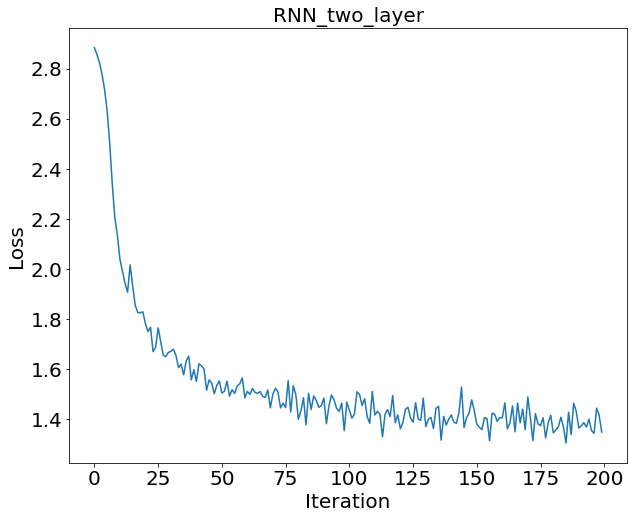

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

plt.subplots(figsize=(10,8))
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('RNN_two_layer',fontsize=20)
plt.plot(all_losses)


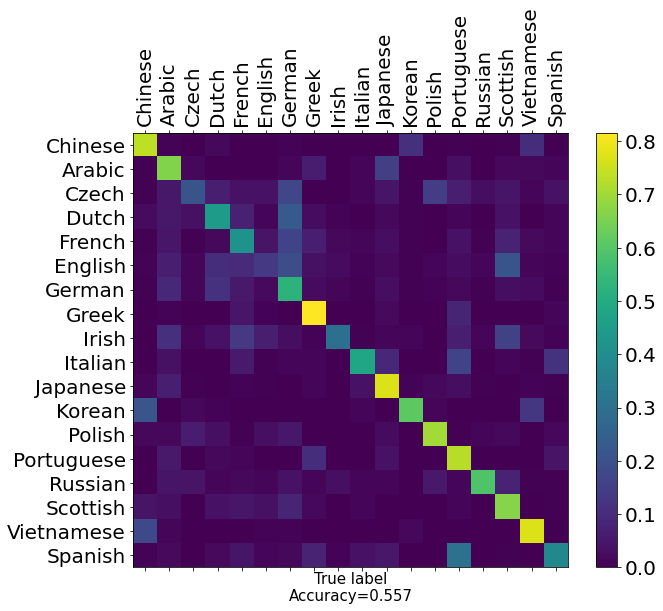

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
y_true=[]
y_pred=[]
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    y_true.append(category_i)
    y_pred.append(guess_i)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()



# Set up plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

score = accuracy_score(y_true, y_pred)
ax.set_xlabel('True label\nAccuracy={:0.3f}'.format(score),fontsize=15)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()